In [ ]:
%pip install catboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
import random
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold

In [ ]:
# # 한글 폰트 설정하기
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumBarunGothic')

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(42)

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
countrywide = pd.read_csv('./countrywide_accident.csv')

# '사고일시' 컬럼을 날짜 형식으로 변환
countrywide['사고일시'] = pd.to_datetime(countrywide['사고일시'])

# 사고유형이 '차대차', '차대사람', '차량단독'인 데이터만 필터링
countrywide = countrywide[countrywide['사고유형'].isin(['차대차', '차대사람', '차량단독'])]

countrywide

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,COUNTRYWIDE_ACCIDENT_000000,2019-01-01 00:00:00,화요일,맑음,서울특별시 강서구 방화동,교차로 - 교차로횡단보도내,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,40세,경상,0,0,1,0,3
1,COUNTRYWIDE_ACCIDENT_000001,2019-01-01 00:00:00,화요일,맑음,경기도 포천시 소흘읍,교차로 - 교차로안,건조,차대차,기타,직진우회전진행방해,...,상해없음,이륜,남,20세,경상,0,0,1,0,3
2,COUNTRYWIDE_ACCIDENT_000002,2019-01-01 00:00:00,화요일,맑음,경기도 양주시 고암동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,17세,중상,0,1,0,0,5
3,COUNTRYWIDE_ACCIDENT_000003,2019-01-01 00:00:00,화요일,맑음,경기도 남양주시 다산동,기타 - 기타,건조,차대사람,횡단중,보행자보호의무위반,...,상해없음,보행자,남,10세,중상,0,2,0,0,10
4,COUNTRYWIDE_ACCIDENT_000004,2019-01-01 00:00:00,화요일,맑음,인천광역시 부평구 부평동,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,승용,남,56세,경상,0,0,2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602770,COUNTRYWIDE_ACCIDENT_602770,2021-12-31 23:00:00,금요일,흐림,부산광역시 해운대구 우동,교차로 - 교차로안,건조,차대차,기타,신호위반,...,상해없음,승합,남,52세,상해없음,0,1,1,0,8
602771,COUNTRYWIDE_ACCIDENT_602771,2021-12-31 23:00:00,금요일,맑음,서울특별시 성동구 행당동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,71세,경상,0,0,2,0,6
602772,COUNTRYWIDE_ACCIDENT_602772,2021-12-31 23:00:00,금요일,맑음,대전광역시 유성구 원신흥동,교차로 - 교차로안,건조,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,56세,경상,0,0,3,0,9
602773,COUNTRYWIDE_ACCIDENT_602773,2021-12-31 23:00:00,금요일,맑음,경기도 화성시 서신면,기타 - 기타,젖음/습기,차량단독,기타,안전운전불이행,...,부상신고,NaN,NaN,NaN,NaN,0,0,0,1,1


In [ ]:
train2 = pd.read_csv('./train.csv')

# '사고일시' 컬럼을 날짜 형식으로 변환
train2['사고일시'] = pd.to_datetime(train2['사고일시'])

train2

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19:00:00,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,28세,경상,0,0,1,0,3
39605,ACCIDENT_39605,2021-12-31 19:00:00,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,52세,경상,0,0,1,0,3
39606,ACCIDENT_39606,2021-12-31 21:00:00,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,중상,승용,남,73세,중상,0,2,0,0,10
39607,ACCIDENT_39607,2021-12-31 22:00:00,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,여,57세,경상,0,0,1,0,3


In [ ]:
train_total = pd.concat([train2, countrywide], ignore_index=True)

# train_total['ECLO'] 열의 null 값 확인
null_count = train_total['ECLO'].isna().sum()

print(f"Number of NaN values in 'ECLO': {null_count}")

train_total

Number of NaN values in 'ECLO': 0


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00:00:00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00:00:00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01:00:00,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02:00:00,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04:00:00,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642367,COUNTRYWIDE_ACCIDENT_602770,2021-12-31 23:00:00,금요일,흐림,부산광역시 해운대구 우동,교차로 - 교차로안,건조,차대차,기타,신호위반,...,상해없음,승합,남,52세,상해없음,0,1,1,0,8
642368,COUNTRYWIDE_ACCIDENT_602771,2021-12-31 23:00:00,금요일,맑음,서울특별시 성동구 행당동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,71세,경상,0,0,2,0,6
642369,COUNTRYWIDE_ACCIDENT_602772,2021-12-31 23:00:00,금요일,맑음,대전광역시 유성구 원신흥동,교차로 - 교차로안,건조,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,56세,경상,0,0,3,0,9
642370,COUNTRYWIDE_ACCIDENT_602773,2021-12-31 23:00:00,금요일,맑음,경기도 화성시 서신면,기타 - 기타,젖음/습기,차량단독,기타,안전운전불이행,...,부상신고,NaN,NaN,NaN,NaN,0,0,0,1,1


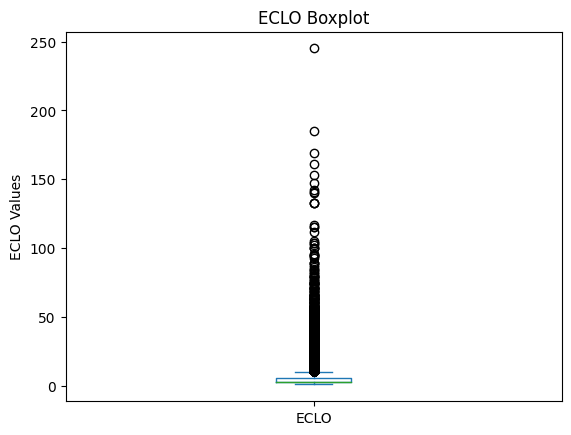

In [ ]:
# 'ECLO' 열의 상자 그림(boxplot)을 그립니다.
train_total['ECLO'].plot(kind='box')
plt.title('ECLO Boxplot')
plt.ylabel('ECLO Values')
plt.show()

In [ ]:
# 'ECLO' 열의 이상치를 정의하기 위해 사분위수를 계산합니다.
Q1 = train_total['ECLO'].quantile(0.25)
Q3 = train_total['ECLO'].quantile(0.75)
IQR = Q3 - Q1

# 사분위수를 이용하여 이상치의 상한선과 하한선을 정의합니다.
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 이상치의 개수를 계산합니다.
outliers_index = train_total[(train_total['ECLO'] < lower_bound) | (train_total['ECLO'] > upper_bound)].index
outlier_count = outliers_index.shape[0]

print("이상치 개수:", outlier_count)

# 이상치가 포함된 행을 삭제합니다.
train_total.drop(outliers_index, inplace=True)

이상치 개수: 37648


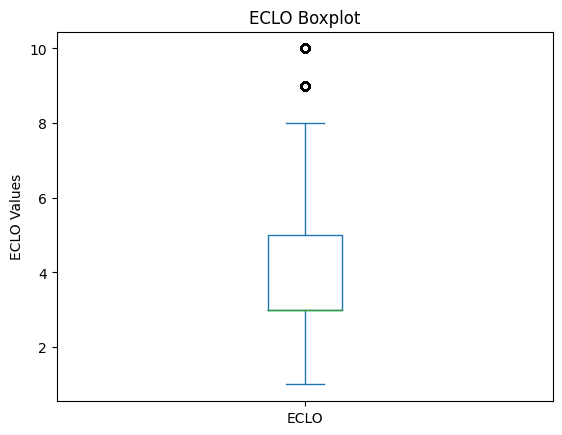

In [ ]:
# 'ECLO' 열의 상자 그림(boxplot)을 그립니다.
train_total['ECLO'].plot(kind='box')
plt.title('ECLO Boxplot')
plt.ylabel('ECLO Values')
plt.show()

In [ ]:
# 'ECLO' 열의 이상치를 정의하기 위해 사분위수를 계산합니다.
Q1 = train_total['ECLO'].quantile(0.25)
Q3 = train_total['ECLO'].quantile(0.75)
IQR = Q3 - Q1

# 사분위수를 이용하여 이상치의 상한선과 하한선을 정의합니다.
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 이상치의 개수를 계산합니다.
outliers_index = train_total[(train_total['ECLO'] < lower_bound) | (train_total['ECLO'] > upper_bound)].index
outlier_count = outliers_index.shape[0]

print("이상치 개수:", outlier_count)

# 이상치가 포함된 행을 삭제합니다.
train_total.drop(outliers_index, inplace=True)

이상치 개수: 39510


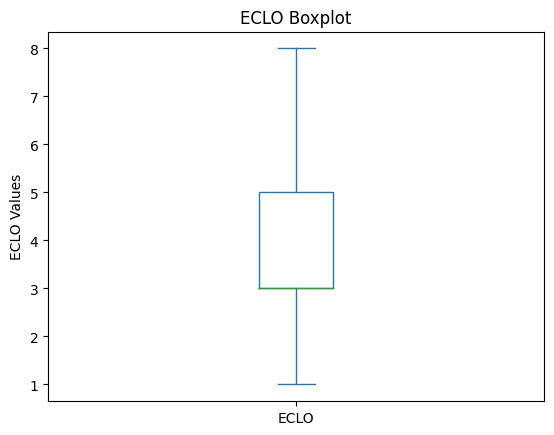

In [ ]:
# 'ECLO' 열의 상자 그림(boxplot)을 그립니다.
train_total['ECLO'].plot(kind='box')
plt.title('ECLO Boxplot')
plt.ylabel('ECLO Values')
plt.show()

In [ ]:
# 'ECLO' 열의 이상치를 정의하기 위해 사분위수를 계산합니다.
Q1 = train_total['ECLO'].quantile(0.25)
Q3 = train_total['ECLO'].quantile(0.75)
IQR = Q3 - Q1

# 사분위수를 이용하여 이상치의 상한선과 하한선을 정의합니다.
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# 이상치의 개수를 계산합니다.
outliers_index = train_total[(train_total['ECLO'] < lower_bound) | (train_total['ECLO'] > upper_bound)].index
outlier_count = outliers_index.shape[0]

print("이상치 개수:", outlier_count)

# 이상치가 포함된 행을 삭제합니다.
train_total.drop(outliers_index, inplace=True)

이상치 개수: 0


In [ ]:
# train_total 데이터프레임에서 '사고유형'별 'ECLO'의 평균 계산
mean_eclo_by_type = train_total.groupby('사고유형')['ECLO'].mean().sort_values(ascending=False)

# 레이블 인코딩을 위한 매핑 딕셔너리 생성
label_mapping = {accident_type: label for label, accident_type in enumerate(mean_eclo_by_type.index)}

# '사고유형' 칼럼을 레이블 인코딩하여 새로운 칼럼 추가
train_total['사고유형_label'] = train_total['사고유형'].map(label_mapping)

# 레이블 인코딩 결과 출력
print("레이블 인코딩 결과:")
print(train_total[['사고유형', '사고유형_label']].drop_duplicates().sort_values(by='사고유형_label'))


레이블 인코딩 결과:
    사고유형  사고유형_label
3    차대차           0
0   차대사람           1
14  차량단독           2


In [ ]:
# '-'를 기준으로 문자열을 분리하여 새로운 컬럼을 만듭니다.
train_total[['도로형태1', '도로형태2']] = train_total['도로형태'].str.split(' - ', expand=True)

In [ ]:
# 주소1에 대한 레이블 인코딩 수행
train_total['도로형태1_label'] = label_encoder.fit_transform(train_total['도로형태1'])

# 주소1_label 값별로 그룹을 형성하여 주소2를 레이블 인코딩
for label_value in train_total['도로형태1_label'].unique():
    # 해당 주소1_label 값과 일치하는 행 추출
    mask = train_total['도로형태1_label'] == label_value
    # 해당 그룹 내의 ECLO 컬럼의 평균값 계산
    mean_eclo = train_total.loc[mask, 'ECLO'].mean()
    # 해당 그룹 내의 주소2를 평균값이 높은 순서대로 숫자 지정하여 레이블 인코딩
    label_dict = {address: idx + 1 for idx, address in enumerate(train_total.loc[mask].sort_values(by='ECLO', ascending=False)['도로형태2'].unique())}
    train_total.loc[mask, '도로형태2_label'] = train_total.loc[mask, '도로형태2'].map(label_dict)

# 주소2_label을 정수형으로 변환
train_total['도로형태2_label'] = train_total['도로형태2_label'].astype(int)

In [ ]:
test = pd.read_csv('./test.csv')
test

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차
...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차


In [ ]:
test[['_', '주소1', '주소2']] = test['시군구'].str.split(n=2, expand=True)

# Dropping the temporary column '_'
test.drop('_', axis=1, inplace=True)
test

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,주소1,주소2
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,수성구,상동
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,수성구,지산동
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,수성구,수성동2가
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,수성구,신매동
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,달서구,감삼동
...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차,남구,대명동
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차,수성구,시지동
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차,수성구,연호동
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차,수성구,범물동


In [ ]:
# '-'를 기준으로 문자열을 분리하여 새로운 컬럼을 만듭니다.
test[['도로형태1', '도로형태2']] = test['도로형태'].str.split(' - ', expand=True)

In [ ]:
# test 데이터프레임에 '도로형태1_label'과 '도로형태2_label' 컬럼을 추가합니다.
test['도로형태1_label'] = None
test['도로형태2_label'] = None

# train 데이터프레임에서 '도로형태1'과 '도로형태1_label' 사이의 매핑을 딕셔너리 형태로 생성합니다.
address1_mapping = dict(zip(train_total['도로형태1'], train_total['도로형태1_label']))

# train 데이터프레임에서 '도로형태2'와 '도로형태2_label' 사이의 매핑을 딕셔너리 형태로 생성합니다.
address2_mapping = dict(zip(train_total['도로형태2'], train_total['도로형태2_label']))

# test 데이터프레임의 각 행에 대해 반복하여 매핑된 값을 할당합니다.
for i, row in test.iterrows():
    # 도로형태1 train 데이터프레임에 있는 경우 해당하는 도로형태1_label 값을 할당합니다.
    if row['도로형태1'] in address1_mapping:
        test.at[i, '도로형태1_label'] = address1_mapping[row['도로형태1']]
    # 도로형태2가 train 데이터프레임에 있는 경우 해당하는 도로형태2_label 값을 할당합니다.
    if row['도로형태2'] in address2_mapping:
        test.at[i, '도로형태2_label'] = address2_mapping[row['도로형태2']]

test

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,주소1,주소2,도로형태1,도로형태2,도로형태1_label,도로형태2_label
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,수성구,상동,교차로,교차로안,0,1
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,수성구,지산동,단일로,기타,2,1
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,수성구,수성동2가,교차로,교차로안,0,1
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,수성구,신매동,단일로,기타,2,1
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,달서구,감삼동,교차로,교차로안,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차,남구,대명동,단일로,터널,2,4
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차,수성구,시지동,단일로,기타,2,1
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차,수성구,연호동,단일로,기타,2,1
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차,수성구,범물동,교차로,교차로부근,0,2


In [ ]:
# train_total 데이터로부터 사고유형에 대한 레이블 인코딩 매핑 생성
accident_type_mapping = {}
for idx, acc_type in enumerate(train_total['사고유형'].unique()):
    accident_type_mapping[acc_type] = idx

# train_total 데이터에 사고유형_label 컬럼 추가
train_total['사고유형_label'] = train_total['사고유형'].map(accident_type_mapping)

# test 데이터에 사고유형_label 컬럼 추가
test['사고유형_label'] = test['사고유형'].map(lambda x: accident_type_mapping.get(x, -1))


In [ ]:
# 모델1에 대한 데이터셋
X1 = train_total[['도로형태1_label', '도로형태2_label']]
y1 = train_total['ECLO']

# 모델2에 대한 데이터셋
X2 = train_total[['사고유형_label']]
y2 = train_total['ECLO']

# 교차 검증을 위한 KFold 객체 생성 (6-겹 교차검증, 랜덤 시드 고정)
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# 모델1에 대한 교차 검증을 수행하고 평균 성능을 출력
cv_scores1 = []
for train_index, val_index in kf.split(X1):
    X_fold_train, X_fold_val = X1.iloc[train_index], X1.iloc[val_index]
    y_fold_train, y_fold_val = y1.iloc[train_index], y1.iloc[val_index]

    model1 = CatBoostRegressor(random_state=42, verbose=0)
    model1.fit(X_fold_train, y_fold_train)
    y_pred = model1.predict(X_fold_val)
    cv_scores1.append(mean_squared_error(y_fold_val, y_pred))

print("모델1 교차 검증 결과:")
print(cv_scores1)
print("모델1 평균 교차 검증 MSE:", np.mean(cv_scores1))

# 모델2에 대한 교차 검증을 수행하고 평균 성능을 출력
cv_scores2 = []
for train_index, val_index in kf.split(X2):
    X_fold_train, X_fold_val = X2.iloc[train_index], X2.iloc[val_index]
    y_fold_train, y_fold_val = y2.iloc[train_index], y2.iloc[val_index]

    model2 = CatBoostRegressor(random_state=42, verbose=0)
    model2.fit(X_fold_train, y_fold_train)
    y_pred = model2.predict(X_fold_val)
    cv_scores2.append(mean_squared_error(y_fold_val, y_pred))

print("모델2 교차 검증 결과:")
print(cv_scores2)
print("모델2 평균 교차 검증 MSE:", np.mean(cv_scores2))

# 새로운 특성 생성
X3 = np.column_stack((model1.predict(X1), model2.predict(X2)))

# 새로운 모델 정의
model_final = CatBoostRegressor(random_state=42, verbose=0)

# 모델 final에 대한 교차 검증을 수행하고 평균 성능을 출력
cv_scores_final = []
for train_index, val_index in kf.split(X3):
    X_fold_train, X_fold_val = X3[train_index], X3[val_index]
    y_fold_train, y_fold_val = y1.iloc[train_index], y1.iloc[val_index]

    model_final.fit(X_fold_train, y_fold_train)
    y_pred = model_final.predict(X_fold_val)
    cv_scores_final.append(mean_squared_error(y_fold_val, y_pred))

print("모델 final 교차 검증 결과:")
print(cv_scores_final)
print("모델 final 평균 교차 검증 MSE:", np.mean(cv_scores_final))

모델1 교차 검증 결과:
[2.385108448029464, 2.391421843208466, 2.3637858461305097, 2.380350299789421, 2.3814191911271863, 2.3790060381250835]
모델1 평균 교차 검증 MSE: 2.3801819444016883
모델2 교차 검증 결과:
[2.3815942115865156, 2.3874564618539273, 2.360378921787607, 2.3752368625836575, 2.3760310446700457, 2.378179052046106]
모델2 평균 교차 검증 MSE: 2.376479425754643
모델 final 교차 검증 결과:
[2.371801126348413, 2.3773627685607193, 2.3497258775403043, 2.366115971099021, 2.366869794836322, 2.366867359048243]
모델 final 평균 교차 검증 MSE: 2.3664571495721707


In [ ]:
# 테스트 데이터에 대한 예측 생성
X1_test = test[['도로형태1_label', '도로형태2_label']]
X2_test = test[['사고유형_label']]

In [ ]:
# 테스트 데이터에 대한 예측 수행
y_pred_test = model1.predict(X1_test)

In [ ]:
# 테스트 데이터에 대한 예측 수행
y_pred_test = model2.predict(X2_test)

In [ ]:
# 모델1과 모델2의 예측값을 특성으로 사용하여 새로운 특성 생성
X3_test = np.column_stack((model1.predict(X1_test), model2.predict(X2_test)))

# 테스트 데이터에 대한 예측 수행
y_pred_test = model_final.predict(X3_test)

# 테스트 예측값 출력
print("테스트 예측값:", y_pred_test)


테스트 예측값: [3.91097081 3.69032159 4.11337089 ... 3.9531427  3.96967291 3.96967291]


In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['ECLO'] = y_pred_test

submission

,ID,ECLO
0,ACCIDENT_39609,3.910971
1,ACCIDENT_39610,3.690322
2,ACCIDENT_39611,4.113371
3,ACCIDENT_39612,3.953143
4,ACCIDENT_39613,4.113371
...,...,...
10958,ACCIDENT_50567,4.317346
10959,ACCIDENT_50568,3.953143
10960,ACCIDENT_50569,3.953143
10961,ACCIDENT_50570,3.969673


In [ ]:
submission.to_csv('./submission.csv', index=False)